In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price              Close          High           Low          Open   Volume
Ticker            SOL.JO        SOL.JO        SOL.JO        SOL.JO   SOL.JO
Date                                                                       
2015-01-01  42979.671875  42979.671875  42979.671875  42979.671875        0
2015-01-02  42978.675781  43571.003703  42681.514635  43409.459724  1010635
2015-01-05  40387.988281  43325.695394  40387.988281  43148.196458  2300587
2015-01-06  39937.261719  40585.432009  39199.344773  40385.994996  3626453
2015-01-07  40228.445312  40503.668428  39543.379081  39950.230642  2509704


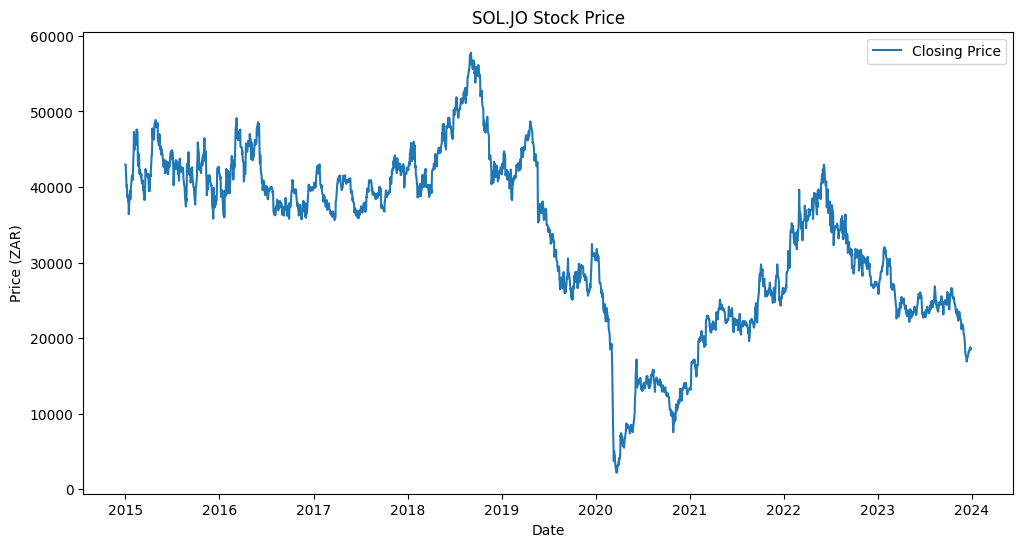

In [2]:
# Get historical stock data (Example: Sasol JSE:SOL)
ticker = "SOL.JO"
df = yf.download(ticker, start="2015-01-01", end="2024-01-01")

# Show the first few rows
print(df.head())

# Plot closing price over time
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label="Closing Price")
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (ZAR)")
plt.legend()
plt.show()



In [3]:
# Feature Engineering

# Moving Averages
df['SMA_50'] = df['Close'].rolling(window=50).mean()  # 50-day SMA
df['SMA_200'] = df['Close'].rolling(window=200).mean()  # 200-day SMA

# Relative Strength Index (RSI)
delta = df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()

rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df['20_SMA'] = df['Close'].rolling(window=20).mean()
rolling_std = df['Close'].rolling(window=20).std()

# **Fix: Ensure rolling_std is a Series**
rolling_std = rolling_std.squeeze()

df['Upper_Band'] = df['20_SMA'] + (rolling_std * 2)
df['Lower_Band'] = df['20_SMA'] - (rolling_std * 2)

# Drop NaN values
df.dropna(inplace=True)

# Show sample data
print(df[['Close', 'SMA_50', 'SMA_200', 'RSI', 'Upper_Band', 'Lower_Band']].tail())


Price              Close        SMA_50       SMA_200        RSI    Upper_Band  \
Ticker            SOL.JO                                                        
Date                                                                            
2023-12-21  18156.416016  22116.133008  23716.807012  23.940247  22760.146854   
2023-12-22  18296.396484  21961.515000  23673.733154  27.942636  22472.866052   
2023-12-27  18813.322266  21805.957109  23635.472119  37.555678  22102.959849   
2023-12-28  18480.371094  21645.639922  23597.090488  39.929998  21637.639522   
2023-12-29  18526.363281  21484.562852  23560.313066  47.935270  21185.920980   

Price         Lower_Band  
Ticker                    
Date                      
2023-12-21  15705.979513  
2023-12-22  15682.204651  
2023-12-27  15766.151479  
2023-12-28  15899.119267  
2023-12-29  16053.779997  


In [4]:
# Select features and target variable
features = ['SMA_50', 'SMA_200', 'RSI', 'Upper_Band', 'Lower_Band']
df['Target'] = df['Close'].shift(-1)  # Next day's closing price

# Drop last row as it has NaN target
df.dropna(inplace=True)

# Split into training and testing sets
X = df[features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


MAE: 692.16
RMSE: 944.69


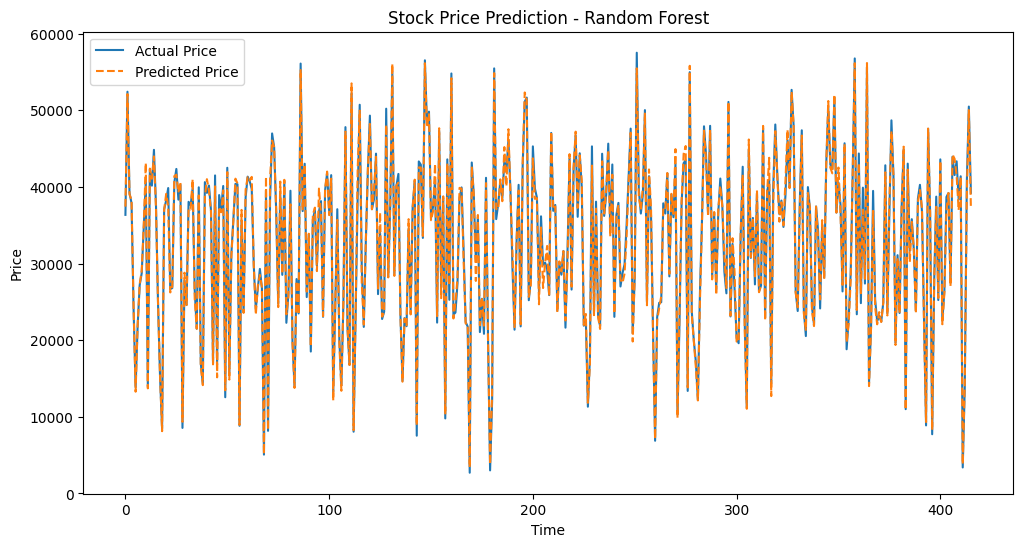

In [5]:
# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Price")
plt.plot(y_pred, label="Predicted Price", linestyle="dashed")
plt.title("Stock Price Prediction - Random Forest")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


XGBoost MAE: 1356.98


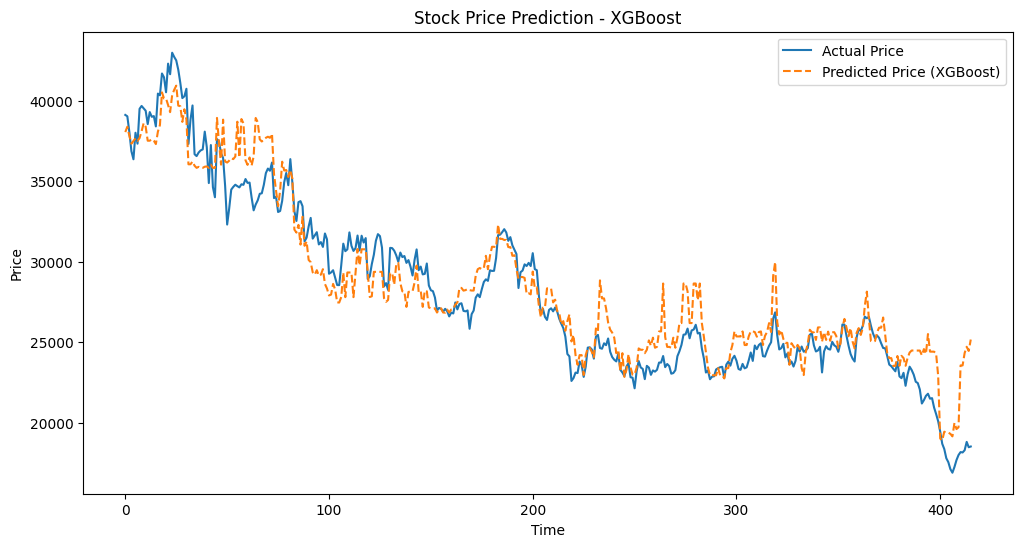

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Fetch stock data (Sasol JSE: SOL)
ticker = "SOL.JO"
df = yf.download(ticker, start="2015-01-01", end="2024-01-01")

# Feature Engineering
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()
df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(14).mean()))

# Drop NaN values
df.dropna(inplace=True)

# Prepare Features and Labels
features = ['SMA_50', 'SMA_200', 'RSI']
X = df[features]
y = df['Close']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost Model
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.05)
model_xgb.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb:.2f}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Price")
plt.plot(y_pred_xgb, label="Predicted Price (XGBoost)", linestyle="dashed")
plt.title("Stock Price Prediction - XGBoost")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
